# Problem Statement

**In the following text mining project, we analyze and dissect U.S. Presidential Speeches given by the different Presidents over the year.
We utilize various Text mining analysis tools to understand and condense the vast text available**

# Loading Packages

In [46]:
library(topicmodels)
library(tidyverse)
library(tidytext)
library(ggplot2)
library(igraph)
library(ggraph)
library(tm)
library(tidyr)
library(purrr)
library(wordcloud2)

In [2]:
speeches <- read.csv('../input/united-states-presidential-speeches/presidential_speeches.csv')

**We read the basic contents of the text**

In [3]:
head(speeches)

Date       President         Party       
1 1789-04-30 George Washington Unaffiliated
2 1789-10-03 George Washington Unaffiliated
3 1790-01-08 George Washington Unaffiliated
4 1790-12-08 George Washington Unaffiliated
5 1790-12-29 George Washington Unaffiliated
6 1791-10-25 George Washington Unaffiliated
  Speech.Title                                          
1 First Inaugural Address                               
2 Thanksgiving Proclamation                             
3 First Annual Message to Congress                      
4 Second Annual Message to Congress                     
5 Talk to the Chiefs and Counselors of the Seneca Nation
6 Third Annual Message to Congress                      
  Summary                                                                                                                                                                                                                                                                                                                                                                                                                      
1 Washington calls on Congress to avoid local and party partisanship and encourages the adoption of a Bill of Rights, without specifically calling them by name. The first President demonstrates his reluctance to accept the post, rejects any salary for the execution of his duties, and devotes a considerable part of the speech to his religious beliefs.                                                               
2 At the request of Congress, Washington establishes November 26th as a national holiday of thanks to God for the successful establishment of the Constitution and government and the liberties the citizens enjoy under the new United States.                                                                                                                                                                                
3 In a wide ranging speech, President Washington addresses the need for a regular army, better roads for communication, and taking a census. An important part of his message highlights the need for establishing a good system of education in the country as a way to guarantee all people understood their rights under the Constitution.                                                                                  
4 Washington focuses on commerce in his second address to Congress, outlining the recent loan deal made in Holland and praising the good harvests for maintaining good public credit. The President warns that any type of war on the seas could pose problems for in 1881. commerce, and he encourages developing a reliable form of American transportation of goods to avoid dependence on Europeans in matters of commerce.
5 The President reassures the Seneca Nation that the new government of the United States devotes itself to the friendship and fair treatment of the Indians. Washington reminds the Indians of their rights to sell and refuse to sell land, assures them of fair treatment by government agents, and gives them the right to redress any of their grievances in American courts.                                              
6 Washington praises the success of the new banks, renounces the need for any additional taxes, and congratulates the public on the good economic situation of the country. After pressing Congress to work on initiatives he proposed months before, the President updates Congress on the Indian situation, and he urges the country to open the justice system to the Indians wishing to use it.                            
  Transcript                                                                                                                                                                                                                                                                                                                                                                                   

**We notice that even the first 6 rows of data are quite long and elaborate with context of the speech,location and President who gave it**

**We try to understand which President gave the highest number of speeches**

In [56]:
presidents <- speeches %>% select(c(President))

In [57]:
pres <- table(presidents)

pres_df <- as.data.frame(pres) %>% arrange(desc(Freq))
head(pres_df)

,presidents,Freq
,<fct>,<int>
1,Lyndon B. Johnson,71
2,Ronald Reagan,59
3,Barack Obama,50
4,Franklin D. Roosevelt,49
5,John F. Kennedy,44
6,Bill Clinton,39


We see the Lyndon Johnson gave the maximum number of speeches and we visualize it below

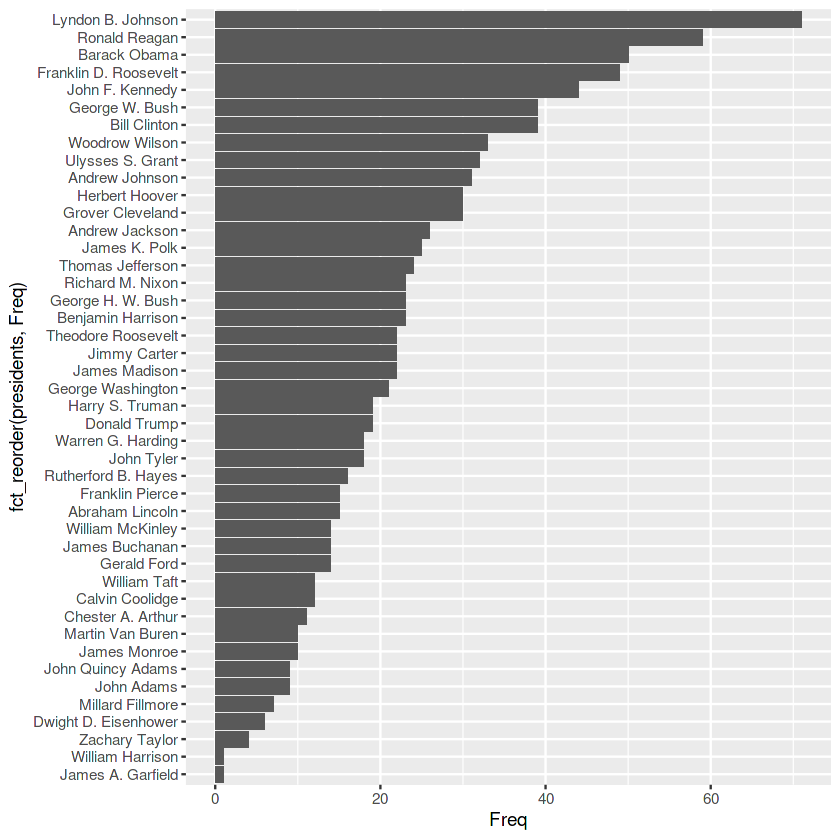

In [6]:
pres_df %>% ggplot(aes(fct_reorder(presidents,Freq),Freq)) +
  geom_col()+
  coord_flip()

**We try to only mine the text within the main contents of Speeches which are in 'Transcript' column**

In [58]:
speeches_text <- speeches %>% select(c(Transcript))

# Tidy Text format

we tokenize the text for easier analysis which is basis for text mining

In [8]:
tidy_speeches <- speeches_text %>% unnest_tokens(word,Transcript)

In [59]:
head(tidy_speeches)

,word
,<chr>
1,fellow
2,citizens
3,of
4,the
5,senate
6,and


**We use stop words to remove redundant words like is,for,the,to and so on to focus on more important words**

In [10]:
text_count <- tidy_speeches %>% anti_join(stop_words)

Joining, by = "word"



After removing stop words, we notice government is the most used word in the speeches

In [53]:
text_count_num <- text_count %>% count(word,sort= TRUE)

head(text_count_num)



,word,n
,<chr>,<int>
1,government,12667
2,people,11398
3,united,10586
4,congress,8062
5,country,7230
6,time,6458


it shows that around 41,000 unique words are present

**We visualize the text instances and frequency**

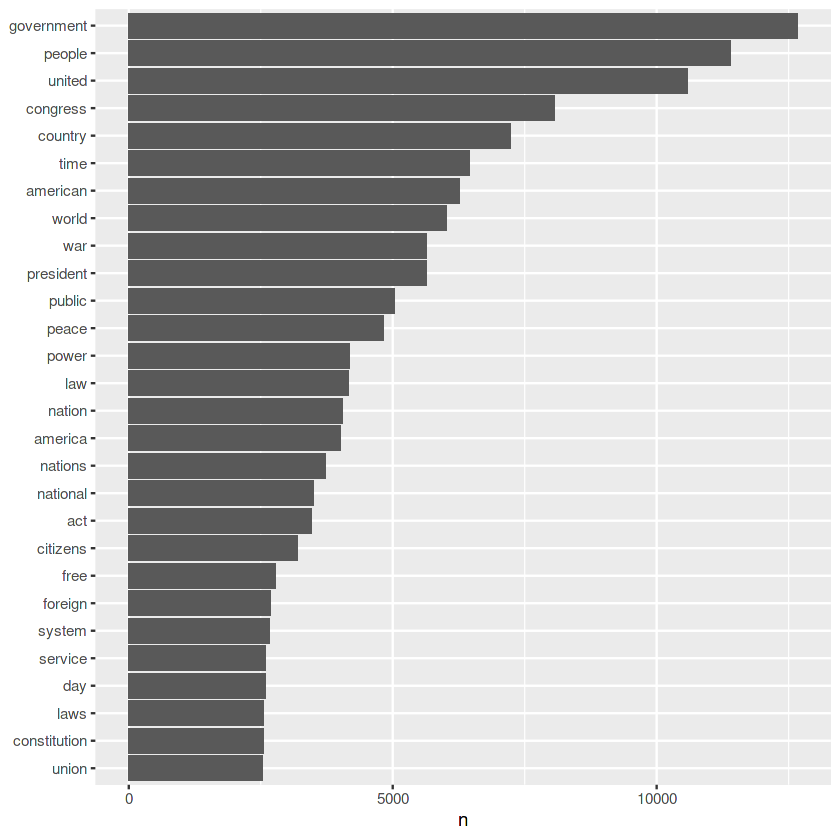

In [13]:
text_count %>%
  count(word, sort = TRUE) %>%
  filter(n > 2500) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(n, word)) +
  geom_col() +
  labs(y = NULL)

# Word Cloud

In [55]:
text_count_cloud <- as.data.frame(text_count_num)

names(text_count_cloud) <- c("words", "frequency")
wordcloud2(text_count_cloud[1:30, ])

HTML widgets cannot be represented in plain text (need html)

# Sentiment Analysis

We use sentiment analysis with tidy data with 'bing' already consisting data requiring for sentiment analysis

In [14]:
sentiment_text <- text_count %>% inner_join(get_sentiments('bing'))%>% count(word,sentiment,sort=TRUE) %>% ungroup()

Joining, by = "word"



In [60]:
head(sentiment_text)
tail(sentiment_text)

,word,sentiment,n
,<chr>,<chr>,<int>
1,peace,positive,4821
2,free,positive,2778
3,freedom,positive,2179
4,support,positive,1808
5,progress,positive,1786
6,proper,positive,1326


,word,sentiment,n
,<chr>,<chr>,<int>
4259,witty,positive,1
4260,woeful,negative,1
4261,worthlessness,negative,1
4262,wreak,negative,1
4263,wreaked,negative,1
4264,wreaks,negative,1


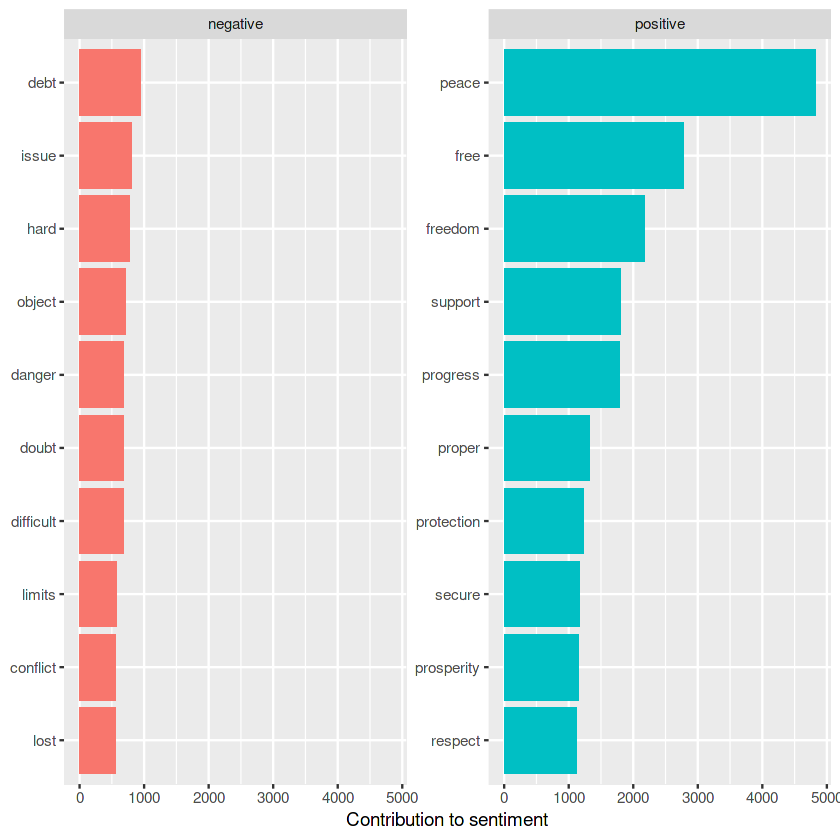

In [61]:
sentiment_text %>%
  group_by(sentiment) %>%
  slice_max(n, n = 10) %>% 
  ungroup() %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(n, word, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment, scales = "free_y") +
  labs(x = "Contribution to sentiment",
       y = NULL)

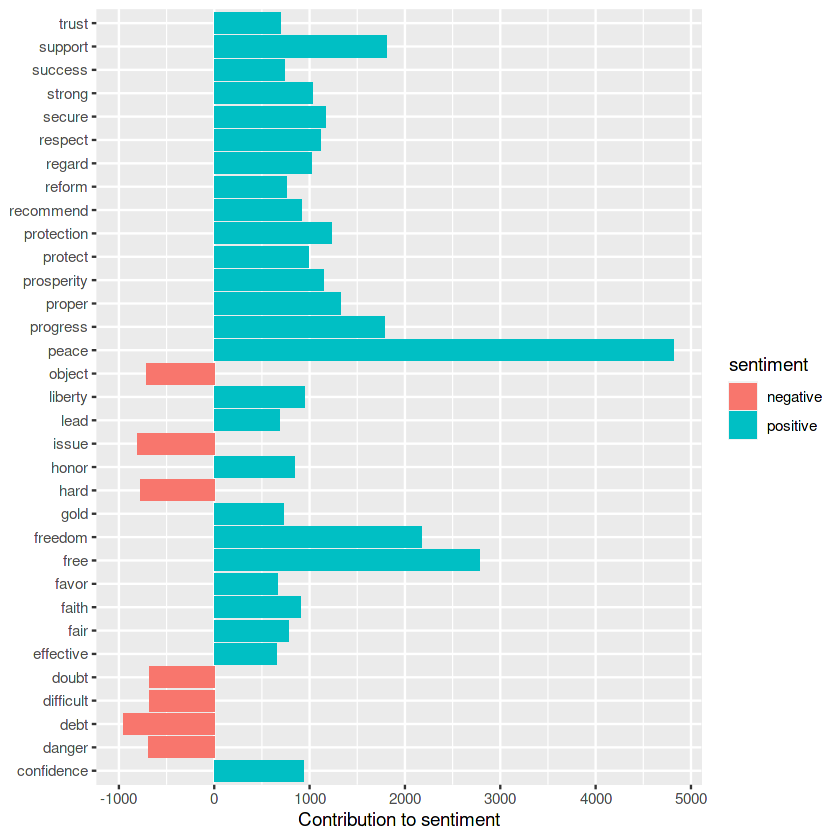

In [62]:
sentiment_text %>%
  count(sentiment,word, wt = n) %>%
  ungroup() %>%
  filter(n >= 650) %>%
  mutate(n = ifelse(sentiment == "negative", -n, n)) %>%
  mutate(term = reorder(word, n)) %>%
  ggplot(aes(n, word, fill = sentiment)) +
  geom_col() +
  labs(x = "Contribution to sentiment", y = NULL)

# Bi-gram analysis 

**Bi- grams are two most common words occuring together**

In [63]:
speeches_bigrams <- speeches_text%>%
                    unnest_tokens(bigram,Transcript,token = 'ngrams',n=2)%>%
                    count(bigram,sort=TRUE)

In [64]:
head(speeches_bigrams)

,bigram,n
,<chr>,<int>
1,of the,57349
2,in the,23497
3,to the,20105
4,and the,11517
5,for the,10799
6,the united,9862


In [65]:
bigrams_separated <- speeches_bigrams %>%
  separate(bigram, c("word1", "word2"), sep = " ")


In [23]:

bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word)

In [24]:
head(bigrams_filtered)

,word1,word2,n
,<chr>,<chr>,<int>
1,american,people,1270
2,federal,government,695
3,soviet,union,592
4,fellow,citizens,547
5,united,nations,535
6,health,care,459


In [25]:
bigrams_united <- bigrams_filtered %>%
  unite(bigram, word1, word2, sep = " ")

In [26]:
head(bigrams_united)

,bigram,n
,<chr>,<int>
1,american people,1270
2,federal government,695
3,soviet union,592
4,fellow citizens,547
5,united nations,535
6,health care,459


In [27]:
bigram_graph <- bigrams_filtered %>%
  filter(n > 100) %>%
  graph_from_data_frame()

In [28]:
bigram_graph

IGRAPH 63a7d73 DN-- 122 84 -- 
+ attr: name (v/c), n (e/n)
+ edges from 63a7d73 (vertex names):
 [1] american->people     federal ->government soviet  ->union     
 [4] fellow  ->citizens   united  ->nations    health  ->care      
 [7] middle  ->east       june    ->30         white   ->house     
[10] viet    ->nam        vice    ->president  public  ->lands     
[13] supreme ->court      public  ->debt       world   ->war       
[16] social  ->security   fellow  ->americans  annual  ->message   
[19] public  ->service    god     ->bless      foreign ->policy    
[22] american->citizens   post    ->office     nuclear ->weapons   
+ ... omitted several edges

# Visualising network of bigrams

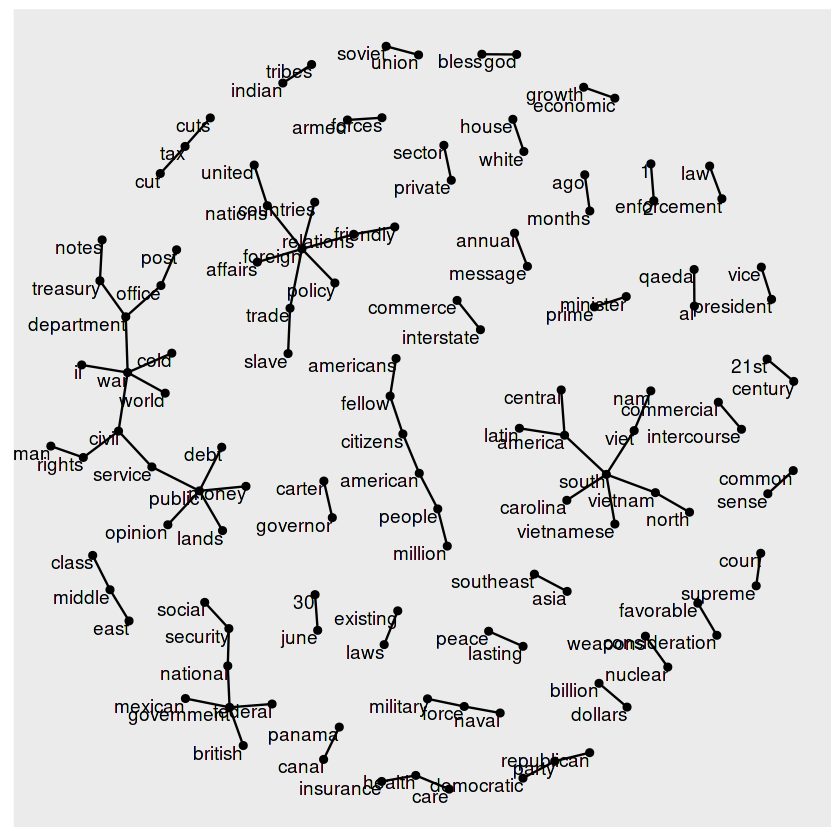

In [29]:
set.seed(2017)

ggraph(bigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

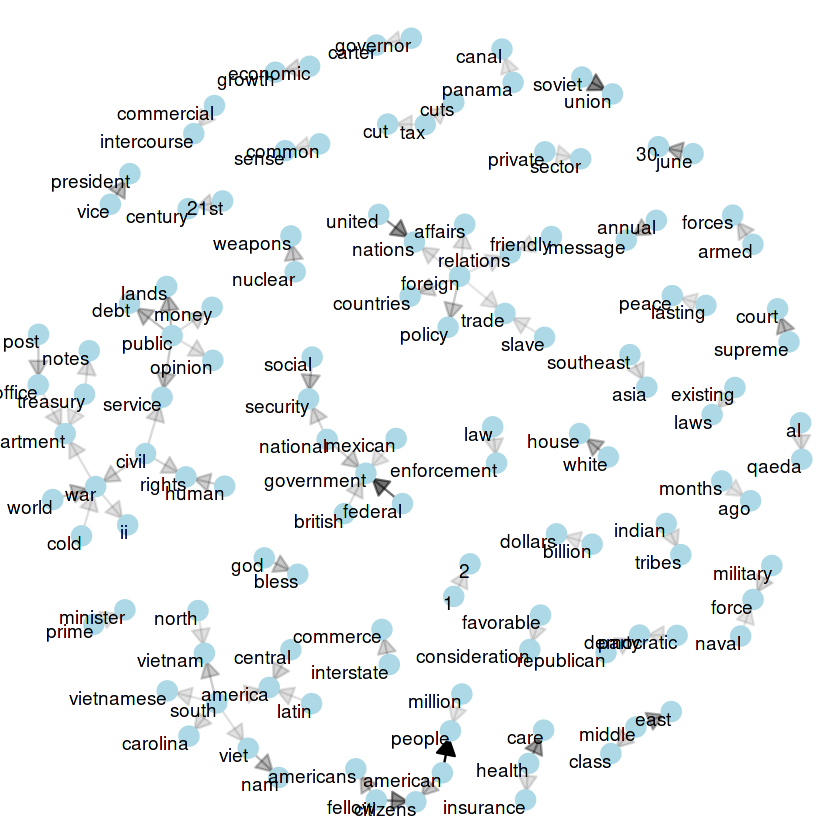

In [30]:
set.seed(2020)

a <- grid::arrow(type = "closed", length = unit(.15, "inches"))

ggraph(bigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

# Topic Modelling 

In text mining, we often have collections of documents, such as blog posts or news articles, that we’d like to divide into natural groups so that we can understand them separately. Topic modeling is a method for unsupervised classification of such documents, similar to clustering on numeric data, which finds natural groups of items even when we’re not sure what we’re looking for.

Latent Dirichlet allocation (LDA) is a particularly popular method for fitting a topic model:

* Every document is a mixture of topics.

* Every topic is a mixture of words

In [31]:
dtm_speeches <- Corpus(VectorSource(speeches_text$Transcript))

In [32]:
review_corpus <- dtm_speeches

In [33]:
review_corpus = tm_map(review_corpus, content_transformer(tolower))
review_corpus = tm_map(review_corpus, removeNumbers)
review_corpus = tm_map(review_corpus, removePunctuation)
review_corpus = tm_map(review_corpus, removeWords, c("the", "and", stopwords("english")))
review_corpus =  tm_map(review_corpus, stripWhitespace)

Warning message in tm_map.SimpleCorpus(review_corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(review_corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(review_corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(review_corpus, removeWords, c("the", "and", :
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(review_corpus, stripWhitespace):
“transformation drops documents”


In [35]:
head(review_corpus)

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 6

In [36]:
dtm_speeches <- DocumentTermMatrix(review_corpus)

dtm_speeches

<<DocumentTermMatrix (documents: 992, terms: 41045)>>
Non-/sparse entries: 839944/39876696
Sparsity           : 98%
Maximal term length: 32
Weighting          : term frequency (tf)

In [37]:
dtm_speeches = removeSparseTerms(dtm_speeches, 0.99)
dtm_speeches

<<DocumentTermMatrix (documents: 992, terms: 10446)>>
Non-/sparse entries: 770226/9592206
Sparsity           : 93%
Maximal term length: 18
Weighting          : term frequency (tf)

In [38]:
rowSum <- apply(dtm_speeches , 1, sum)

In [39]:
dtm_speeches_zeros <-dtm_speeches[rowSum> 0,]

In [40]:
lda_speeches <- LDA(dtm_speeches_zeros, k = 2, control = list(seed = 1234))

In [41]:
lda_speeches

A LDA_VEM topic model with 2 topics.

In [42]:
speech_topics <- tidy(lda_speeches, matrix = "beta")
head(speech_topics)

topic,term,beta
<int>,<chr>,<dbl>
1,accomplished,3.573905e-04
2,accomplished,1.032891e-04
1,accordingly,1.602318e-04
2,accordingly,9.887253e-06
1,acknowledge,5.890851e-05
2,acknowledge,5.513907e-05


**We observe below that topic modelling is not showing great results as there are similar context of words in both the models**

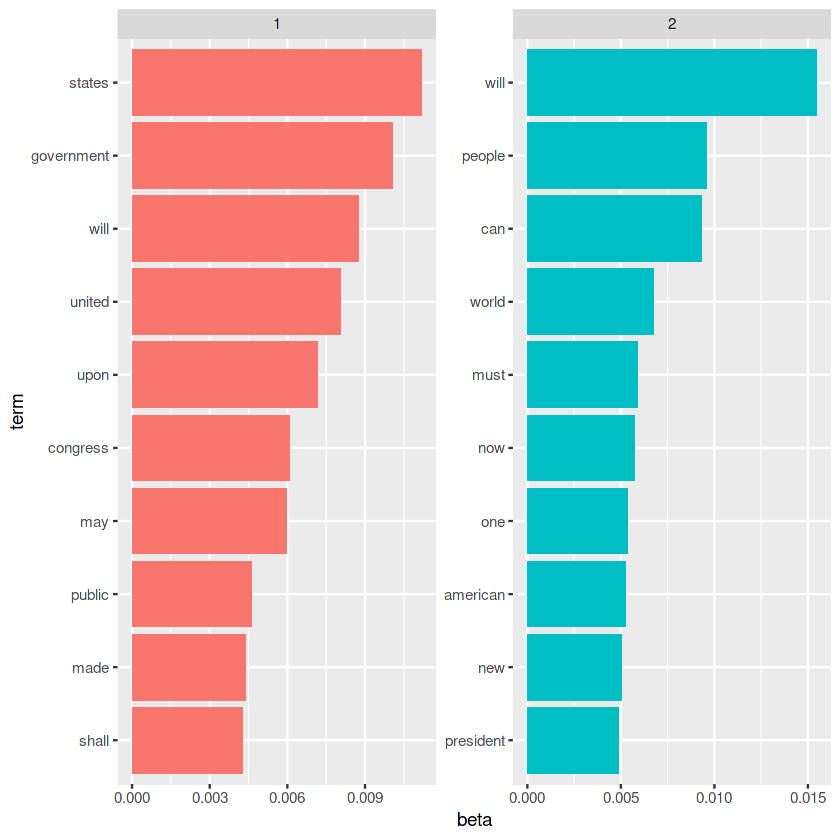

In [43]:
speech_top_terms <- speech_topics %>%
  group_by(topic) %>%
  slice_max(beta, n = 10) %>% 
  ungroup() %>%
  arrange(topic, -beta)

speech_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()

**Above we did basic text mining analysis of data using different methods and tools**